In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import ShuffleSplit
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import pylab
import random
from sklearn.model_selection import KFold
import plotly.express as px
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestRegressor
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
from  sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR
import dateutil
from datetime import datetime

from dateutil.relativedelta import relativedelta
from mlxtend.evaluate import PredefinedHoldoutSplit
import kneed
import kaleido
%run functions.ipynb

<IPython.core.display.Javascript object>

In [2]:
station = "kahl"

In [3]:
#OPTIONS:  "OPO4P", "NO3N", "NH4N", "TRP"
predict = "NO3N"
test_model = "rf"

In [4]:
if test_model == "rf":
    algo = RandomForestRegressor(n_jobs = -1)
elif test_model == "lr":
    algo = linear_model.LinearRegression()

In [6]:
# Here we are inputting the cleaned data that has been saved
df = pd.read_csv(r'./data/cleaned_up_data/%s_%s_final.csv' %(station, predict))
df['Datum'] = pd.to_datetime(df['Datum'])
df= df.set_index("Datum")
df

,O2,Temp,pH,month_sin,month_cos,week_sin,week_cos,NO3N,flow,Conduct
Datum,,,,,,,,,,
2017-09-16 00:00:00,8.1,16.3,7.9,-1.000000,-1.836970e-16,-0.947326,-0.320270,2.9,181.0,565.0
2017-09-16 00:15:00,8.1,16.3,7.9,-1.000000,-1.836970e-16,-0.947326,-0.320270,2.9,173.0,565.0
2017-09-16 00:30:00,8.1,16.3,7.9,-1.000000,-1.836970e-16,-0.947326,-0.320270,2.9,173.0,566.0
2017-09-16 00:45:00,8.1,16.3,7.9,-1.000000,-1.836970e-16,-0.947326,-0.320270,2.9,171.0,566.0
2017-09-16 01:00:00,8.1,16.3,7.9,-1.000000,-1.836970e-16,-0.947326,-0.320270,2.9,171.0,567.0
...,...,...,...,...,...,...,...,...,...,...
2021-08-31 22:45:00,7.6,19.0,8.1,-0.866025,-5.000000e-01,-0.845596,-0.533823,3.5,119.0,682.0
2021-08-31 23:00:00,7.6,19.0,8.1,-0.866025,-5.000000e-01,-0.845596,-0.533823,3.5,119.0,682.0
2021-08-31 23:15:00,7.5,19.0,8.1,-0.866025,-5.000000e-01,-0.845596,-0.533823,3.5,122.0,682.0


In [7]:
df.describe()

,O2,Temp,pH,month_sin,month_cos,week_sin,week_cos,NO3N,flow,Conduct
count,94926.000000,94926.000000,94926.000000,9.492600e+04,9.492600e+04,94926.000000,94926.000000,94926.000000,94926.000000,94926.000000
mean,9.685095,14.388819,8.016314,-4.376606e-02,-5.880968e-02,-0.022342,-0.076995,3.660647,135.409370,617.457260
std,2.573869,7.237780,0.188428,6.969981e-01,7.133232e-01,0.701827,0.707830,0.789820,70.122334,67.838287
min,4.200000,1.100000,7.500000,-1.000000e+00,-1.000000e+00,-0.999561,-0.998244,2.100000,100.000000,408.000000
25%,7.500000,6.900000,7.900000,-8.660254e-01,-8.660254e-01,-0.737833,-0.794854,3.200000,100.900000,578.000000
50%,9.300000,14.900000,8.000000,-2.449294e-16,-1.836970e-16,0.059241,-0.088796,3.600000,104.000000,634.000000
75%,11.900000,21.100000,8.100000,5.000000e-01,5.000000e-01,0.652822,0.582979,4.300000,145.000000,667.000000
max,17.400000,27.600000,8.500000,1.000000e+00,1.000000e+00,0.999561,1.000000,5.500000,487.000000,751.000000


In [8]:
# this cell splits the data into 80:20 ratio, for training and testing. Training dataset is named manual_train
# testing dataset is named manual_test

list_feat = df.columns.drop(predict)
temp_df_1 = df.reset_index()
    
column_headers = [x for x in temp_df_1.columns]
time_df = pd.DataFrame(columns= column_headers)

last_date = temp_df_1.iloc[-2,0]
temp_date = temp_df_1.iloc[0,0]
i = 0
while temp_date.month != last_date.month or temp_date.year != last_date.year:
    temp_date = temp_df_1.iloc[0,0] + pd.DateOffset(months =i)
    temp = temp_df_1[(temp_df_1.Datum.dt.month == temp_date.month) & (temp_df_1.Datum.dt.year==temp_date.year) ]
                
    temp2 = temp.sample(frac = 20*0.01, random_state = 1)
            
    time_df = pd.concat([time_df, temp2], axis = 0)
    i = i+1


time_df = time_df.drop_duplicates(subset=['Datum'], keep='first')
dates = np.array(time_df["Datum"])
time_df= time_df.set_index("Datum")
manual_train = temp_df_1.set_index("Datum")
manual_train.drop(dates, inplace=True)

manual_test = time_df

# here both the test and train dataframe are included with timestamps

In [12]:
manual_test.describe()

,O2,Temp,pH,month_sin,month_cos,week_sin,week_cos,NO3N,flow,Conduct
count,18984.000000,18984.000000,18984.000000,1.898400e+04,1.898400e+04,18984.000000,18984.000000,18984.000000,18984.000000,18984.000000
mean,9.682181,14.379307,8.014728,-4.382395e-02,-5.877267e-02,-0.022686,-0.077010,3.660666,135.517169,617.385895
std,2.590410,7.240022,0.188590,6.970067e-01,7.133437e-01,0.701922,0.707751,0.788158,70.052952,68.229735
min,4.200000,1.100000,7.500000,-1.000000e+00,-1.000000e+00,-0.999561,-0.998244,2.100000,100.000000,408.000000
25%,7.500000,6.900000,7.900000,-8.660254e-01,-8.660254e-01,-0.737833,-0.794854,3.200000,100.900000,579.000000
50%,9.300000,14.800000,8.000000,-2.449294e-16,-1.836970e-16,0.059241,-0.088796,3.600000,104.000000,634.000000
75%,11.900000,21.100000,8.100000,5.000000e-01,5.000000e-01,0.652822,0.582979,4.300000,145.000000,667.000000
max,17.400000,27.600000,8.500000,1.000000e+00,1.000000e+00,0.999561,1.000000,5.500000,487.000000,751.000000


### change tt to manual_train

In [13]:
# Testing of the model (Linear Regression or Random Forest) through cross-validation.
# The cross validation technique used is ShuffleSplit where model is trained over randomly selected 80% of the data and
# tested over the remaining 20%. Model is run 5 times, R2 and RMSE is reported as the average of the five runs.

temp_df_2= manual_train

arr_r2 = []
arr_RMSE = []

list_feat = temp_df_2.columns.drop(predict)
X = np.array(temp_df_2[list_feat])
y = np.array(temp_df_2[[predict]])

split_algo = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)

for train_index, test_index in split_algo.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    algo.fit(X_train, y_train.ravel())
    predictions = algo.predict(X_test)
    
    temp = r2_score(y_test, predictions)
    arr_r2.append(temp)


    temp2 = mean_squared_error(y_test, predictions, squared=False)
    arr_RMSE.append(temp2)
    
r2 = np.average(arr_r2)
rmse = np.average(arr_RMSE)

print("Cross Validation results | ", test_model, " | " , station)
print("Rsquared", predict, "\n", r2)
print('RMSE ', predict, '\n', rmse)

Cross Validation results |  rf  |  kahl
Rsquared NO3N 
 0.9992097966098417
RMSE  NO3N 
 0.02214709778586178


In [17]:
#delete
manual_train = manual_train.sample(frac=0.1)
manual_train = manual_train.sort_index()
manual_train

,O2,Temp,pH,month_sin,month_cos,week_sin,week_cos,NO3N,flow,Conduct
Datum,,,,,,,,,,
2017-09-16 02:00:00,8.1,16.2,7.9,-1.000000,-1.836970e-16,-0.947326,-0.320270,2.9,171.0,569.0
2017-09-16 05:15:00,8.1,16.1,7.9,-1.000000,-1.836970e-16,-0.947326,-0.320270,3.0,169.0,572.0
2017-09-16 08:00:00,8.1,16.0,7.9,-1.000000,-1.836970e-16,-0.947326,-0.320270,3.0,167.0,575.0
2017-09-16 10:00:00,8.2,16.0,7.9,-1.000000,-1.836970e-16,-0.947326,-0.320270,3.0,187.0,580.0
2017-09-16 11:30:00,8.3,16.0,7.9,-1.000000,-1.836970e-16,-0.947326,-0.320270,3.0,185.0,586.0
...,...,...,...,...,...,...,...,...,...,...
2021-08-30 05:15:00,7.5,19.3,8.1,-0.866025,-5.000000e-01,-0.845596,-0.533823,3.4,100.0,674.0
2021-08-30 07:00:00,7.4,19.3,8.0,-0.866025,-5.000000e-01,-0.845596,-0.533823,3.5,100.0,675.0
2021-08-31 02:30:00,7.4,19.1,8.1,-0.866025,-5.000000e-01,-0.845596,-0.533823,3.5,128.0,673.0


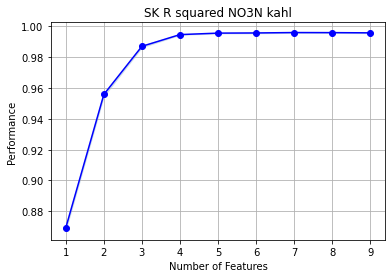

Wall time: 3min 31s


<IPython.core.display.Javascript object>

In [18]:
%%notify
%%time


sklearn_r2 = make_scorer(r2_score, greater_is_better=True )
X = np.array(manual_train[list_feat])
y = np.array(manual_train[[predict]])

split_algo = ShuffleSplit(test_size=0.20, random_state=0)
cv_gen = split_algo.split(X, y)
cv = list(cv_gen)

sfs = SFS(algo,
          k_features=(len(list_feat)),
          forward=True,
          floating=False, 
          scoring= sklearn_r2, 
          cv=cv)
sfs = sfs.fit(X, y.ravel())

fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
plt.title("SK R squared %s %s" % (predict, station))
plt.grid()
plt.show()

In [19]:
# Displaying the order in which features are entered in the model
temp1_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
display(temp1_df)
temp3 = column_dict(manual_train[list_feat])
feature_list =  order_of_features(temp1_df, temp3)
print(feature_list)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(5,)","[0.8656740381827404, 0.8692034078841062, 0.871...",0.869309,"(5,)",0.003133,0.004218,0.001406
2,"(1, 5)","[0.9526152266031538, 0.9594204127539144, 0.957...",0.955823,"(1, 5)",0.002519,0.003391,0.00113
3,"(1, 5, 8)","[0.9879328296553508, 0.9874871055068848, 0.985...",0.987074,"(1, 5, 8)",0.001466,0.001974,0.000658
4,"(1, 2, 5, 8)","[0.9959851252602796, 0.9947541417214777, 0.995...",0.994702,"(1, 2, 5, 8)",0.000449,0.000604,0.000201
5,"(0, 1, 2, 5, 8)","[0.9968053728460803, 0.9955114196981821, 0.995...",0.995661,"(0, 1, 2, 5, 8)",0.000461,0.000621,0.000207
6,"(0, 1, 2, 3, 5, 8)","[0.9970739467437554, 0.9965434809414725, 0.996...",0.995771,"(0, 1, 2, 3, 5, 8)",0.000521,0.000702,0.000234
7,"(0, 1, 2, 3, 4, 5, 8)","[0.9970181478548265, 0.9967216049833976, 0.996...",0.996031,"(0, 1, 2, 3, 4, 5, 8)",0.000442,0.000595,0.000198
8,"(0, 1, 2, 3, 4, 5, 7, 8)","[0.9968852582540884, 0.9968049591628322, 0.995...",0.995979,"(0, 1, 2, 3, 4, 5, 7, 8)",0.00045,0.000606,0.000202
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)","[0.9966808973421366, 0.9969515934100368, 0.995...",0.995846,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",0.000493,0.000664,0.000221


['week_sin', 'Temp', 'Conduct', 'pH', 'O2', 'month_sin', 'month_cos', 'flow', 'week_cos']


In [23]:
# This has been hard coded after extreme analysis, but these five features are mostly the features taht you will get from above.
if test_model == "lr" and station == "kahl" and predict == "NO3N":
    list_feat = ["month_sin","Temp","pH","week_sin","Conduct"]
    
if test_model == "lr" and station == "kahl" and predict == "OPO4P":
    list_feat = ["O2","pH","month_sin", "month_cos", "week_sin"]

if test_model == "lr" and station == "kahl" and predict == "NH4N":
    list_feat = ["week_cos","Conduct","pH", "week_sin","month_sin"]
    
if test_model == "lr" and station == "erlabrunn" and predict == "NO3N":
    list_feat = ["month_sin","Temp", "Conduct","week_sin","month_cos"]

if test_model == "lr" and station == "erlabrunn" and predict == "OPO4P":
    list_feat = ["month_sin","flow","O2","Temp","Conduct"]
    
if test_model == "rf" and station == "kahl" and predict == "NO3N":
    list_feat = ["week_sin","Conduct","Temp","O2","month_sin"]  

if test_model == "rf" and station == "kahl" and predict == "OPO4P":
    list_feat = ["week_sin","Conduct","Temp","flow","O2"]
    
if test_model == "rf" and station == "kahl" and predict == "NH4N":
    list_feat = ["week_sin","Conduct","Temp","O2","flow"]
    
if test_model == "rf" and station == "erlabrunn" and predict == "NO3N":
    list_feat = ["week_sin","Conduct","Temp","flow","pH"]

if test_model == "rf" and station == "erlabrunn" and predict == "OPO4P":
    list_feat = ["week_sin","flow","Conduct","Temp","O2"]

### Grid Search

In [24]:
# Number of trees in random forest
n_estimators = [50]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 20, 30]
# Minimum number of samples required to split a node
min_samples_split = [6, 12, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [6, 12, 20]


# Create the param grid
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
print(param_grid)
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = algo, param_grid = param_grid,  verbose=2, n_jobs = -1)

{'n_estimators': [50], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30], 'min_samples_split': [6, 12, 20], 'min_samples_leaf': [6, 12, 20], 'bootstrap': [True, False]}


In [25]:
X = np.array(manual_train[list_feat])
y = np.array(manual_train[[predict]])

rf_Grid.fit(X, y.ravel())

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [6, 12, 20],
                         'min_samples_split': [6, 12, 20],
                         'n_estimators': [50]},
             verbose=2)

In [26]:
best_hyper = rf_Grid.best_params_
print(best_hyper)

model = RandomForestRegressor(bootstrap = best_hyper.get('bootstrap'), 
                                  max_depth= best_hyper.get('max_depth'),
                                  max_features= best_hyper.get("max_features"),
                                  min_samples_leaf= best_hyper.get("min_samples_leaf"),
                                  min_samples_split = best_hyper.get("min_samples_split") ,
                                  n_estimators=100, n_jobs = -1)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 20, 'n_estimators': 50}


### Testing on the unseen dataset i.e the 20% of the earlier separated dataset. The model is trained on the top 5 features that are mentioned above. 

In [27]:
arr_r2 = []
arr_RMSE = []

# list_feat = manual_train.columns.drop(predict)

    #train
X_train = np.array(manual_train[list_feat])
y_train = np.array(manual_train[[predict]])

    #test
X_test = np.array(manual_test[list_feat])
y_test = np.array(manual_test[[predict]])

model.fit(X_train,  y_train.ravel())
predictions = model.predict(X_test)

temp_r2 = r2_score(y_test, predictions)
arr_r2.append(temp_r2)

temp_rmse = mean_squared_error(y_test, predictions, squared=False)
arr_RMSE.append(temp_rmse)

print("Rsquared", predict, "\n", temp_r2)
print('RMSE ', predict, '\n', temp_rmse)
print( "***")

Rsquared NO3N 
 0.9802989594938991
RMSE  NO3N 
 0.11062322002979907
***


In [47]:
obs_vs_pred_df = pd.DataFrame({
    'Datum': manual_test.reset_index()["Datum"].values,
    f'{predict}': manual_test[predict],
    f'Predicted_{predict}': predictions
})

# Setting index to 'Datum' and sorting by the index
obs_vs_pred_df = obs_vs_pred_df.set_index('Datum').sort_index()


figx = px.line(obs_vs_pred_df, x = obs_vs_pred_df.index, y=[predict, "Predicted_%s" %(predict)], title = "%s" %(station))
figx.update_xaxes(rangeslider_visible = True)
# figx.update_layout(yaxis_range=[0, 0.2])
print("full")
print("Rsquared", predict, "\n", temp_r2)
print('RMSE ', predict, '\n', temp_rmse)
figx.show()

full
Rsquared NO3N 
 0.9802989594938991
RMSE  NO3N 
 0.11062322002979907


### Determination of Knee

In [53]:
arr_r2 = []
arr_RMSE = []
samples_per_month = [1, 3, 5, 10, 20, 30, 80, 100,120, 150, 175, 180, 190, 200, 210, 225, 250, 275, 300, 325, 350,
                     375, 400, 425, 450, 475, 500,600,700, 800, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,
                     1800, 2001, 2200, 2400]
# samples_per_month = [samples]

In [54]:
# Training the vanilla RF model on 40 different sampling frequencies and testing them on the 20% of the entire dataset.
for j in samples_per_month:
    ss = manual_train.reset_index()
    tt = manual_test
    
    boss_list = [x for x in ss.columns]
    time_df = pd.DataFrame(columns= boss_list)

    last_date = ss.iloc[-2,0]
    temp_date = ss.iloc[0,0]
    i = 0
    while temp_date.month != last_date.month or temp_date.year != last_date.year:
        temp_date = ss.iloc[0,0] + pd.DateOffset(months =i)
        temp = ss[(ss.Datum.dt.month == temp_date.month) & (ss.Datum.dt.year==temp_date.year) ]
#         print("Number of data points in ", temp_date.month, " : ", len(temp) )
        
        if len(temp) > j:
            temp2 = temp.sample(n = j, random_state = 1)
        elif len(temp) < j:
            temp2 = temp.sample(frac = 0.95, random_state = 1)
            
        time_df = pd.concat([time_df, temp2], axis = 0)
        i = i+1

    time_df = time_df.drop_duplicates(subset=['Datum'], keep='first')
#     dates = np.array(time_df["Datum"])
    time_df = time_df.set_index("Datum")
#     ss = ss.set_index("Datum")
#     ss.drop(dates, inplace=True)
    
#     display(ss)
#     display(time_df)

#     list_feat = time_df.columns.drop(predict)   NOT USING THIS JUST TO SEE HOW MUCH IT CHANGES IF WE USE LESSER PREDICTORS

    #train
    X_train = np.array(time_df[list_feat])
    y_train = np.array(time_df[[predict]])

    #test
    X_test = np.array(tt[list_feat])
    y_test = np.array(tt[[predict]])

    model = RandomForestRegressor(n_jobs = -1)
    model.fit(X_train,  y_train.ravel())
    predictions = model.predict(X_test)

    temp_r2 = r2_score(y_test, predictions)
    arr_r2.append(temp_r2)

    temp_rmse = mean_squared_error(y_test, predictions, squared=False)
    arr_RMSE.append(temp_rmse)

    print(j)
    print("Rsquared", predict, "\n", temp_r2)
    print('RMSE ', predict, '\n', temp_rmse)
    print( "***")

1
Rsquared NO3N 
 0.8548962971537203
RMSE  NO3N 
 0.30022092687052054
***
3
Rsquared NO3N 
 0.9080165583998632
RMSE  NO3N 
 0.23903227298734883
***
5
Rsquared NO3N 
 0.9214035832176963
RMSE  NO3N 
 0.22095462027392898
***
10
Rsquared NO3N 
 0.9530306376869139
RMSE  NO3N 
 0.1708083296914798
***
20
Rsquared NO3N 
 0.9696985900734194
RMSE  NO3N 
 0.13719337252932934
***
30
Rsquared NO3N 
 0.9761901283264831
RMSE  NO3N 
 0.12161306698944395
***
80
Rsquared NO3N 
 0.9918940707090391
RMSE  NO3N 
 0.07095828645530991
***
100
Rsquared NO3N 
 0.9926068884156052
RMSE  NO3N 
 0.06776654502580241
***
120
Rsquared NO3N 
 0.9937891033567906
RMSE  NO3N 
 0.06211247928186091
***
150
Rsquared NO3N 
 0.9948349133777563
RMSE  NO3N 
 0.05664225286945166
***
175
Rsquared NO3N 
 0.995413583812118
RMSE  NO3N 
 0.053375068407459654
***
180
Rsquared NO3N 
 0.9954554761400283
RMSE  NO3N 
 0.053130745264011174
***
190
Rsquared NO3N 
 0.9956720100876107
RMSE  NO3N 
 0.0518495311650585
***
200
Rsquared NO3N 
 0.9

In [55]:
# Combining the result of 40 runs in a pandas dataframe
results = pd.DataFrame(list(zip(samples_per_month, arr_r2, arr_RMSE)),
               columns =['Samples Per Month', 'R2', 'RMSE'])
results = results.sort_values('Samples Per Month')
# results.to_csv(r'%s_%s_numbers_3_more_freq.csv' %(station, predict), index = False, header = True)
results

,Samples Per Month,R2,RMSE
0,1,0.854896,0.300221
1,3,0.908017,0.239032
2,5,0.921404,0.220955
3,10,0.953031,0.170808
4,20,0.969699,0.137193
5,30,0.976190,0.121613
6,80,0.991894,0.070958
7,100,0.992607,0.067767
8,120,0.993789,0.062112
9,150,0.994835,0.056642


kahl NO3N
Frequency:  9.64506e-05
Samples per month:  249.9999552
Hourly frequency:  2.8800005161  hours


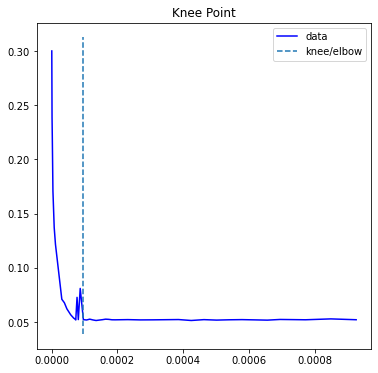

In [56]:
# Determination of knee using kneedle algorithm

x = np.array(results[["Samples Per Month"]].div(2592000)).squeeze()
y = np.array(results[["RMSE"]]).squeeze()

kneedle = kneed.KneeLocator(x, y, S=9.0, curve="convex", direction="decreasing")
freq = round(kneedle.knee, 10)  # knee point frequency in Hz

print(station, predict)
print ("Frequency: ", freq)

freq_m = freq*30*24*60*60   # Converting the frequency in Hz to samples per month
print("Samples per month: ", freq_m)   

print("Hourly frequency: ", round(30/freq_m*24, 10), " hours") # Converting the frequency in Hz to hourly

kneedle.plot_knee()